#### CV Project 2 Part 1
DOMAIN: Entertainment
CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
PROJECT OBJECTIVE: Face detection from training images.

Steps and tasks: [ Total Score: 20 points]
1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:
#####  Design a face mask detection model.
##### Hint: Use U-net along with pre-trained transfer learning models
##### Design your own Dice Coeffcient and Loss function.
##### Train, tune and test the model.
##### Evaluate the model using testing data.
4. Use the “Prediction image” as an input to your designed model and display the output of the image.
Acknowledgement for the dataset http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/
Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf

Step 1. Import the dataset.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob

In [2]:
data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

In [3]:
data.shape

(409, 2)

Data has 409 entries

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
import warnings
warnings.filterwarnings('ignore')

2021-12-04 18:57:28.172738: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-12-04 18:57:28.172849: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-12-04 18:57:28.172861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Step 2. Create features (images) and labels (mask) using that data.

In [5]:
images = data[:,0]
mask = data[:,1]


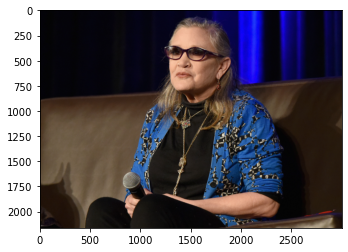

In [6]:
plt.imshow(images[130])

In [7]:
print(images.shape,mask.shape)

(409,) (409,)


In [8]:
images[0].shape

(333, 650, 3)

Image size is 333x650x3. It is an RGB image.

In [9]:
print(mask[123])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7669172932330827, 'y': 0.2229965156794425}, {'x': 0.8947368421052632, 'y': 0.44947735191637633}], 'imageWidth': 399, 'imageHeight': 287}]


We resize the image to 224x224 (height=224 and width = 224)

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224
ALPHA = 1

In [11]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [12]:
X.shape

(409, 224, 224, 3)

In [13]:
masks.shape

(409, 224, 224)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2,random_state=42)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


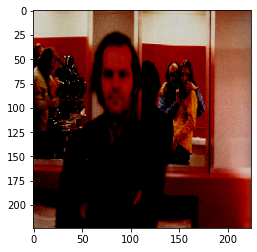

In [15]:
n = 15
#print(X_train[n])
plt.imshow(X_train[n])

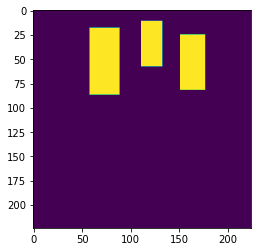

In [16]:
plt.imshow(masks[n])

##### Design your own Dice Coeffcient and Loss function.

In [17]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

##### 3. Mask detection model

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [19]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

2021-12-04 18:57:31.983345: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-04 18:57:31.985835: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-04 18:57:31.985879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lenovo-Lenovo-ideapad-520-15IKB): /proc/driver/nvidia/version does not exist
2021-12-04 18:57:31.986237: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-12-04 18:57:32.013418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2021-12-04 18:57:32.014036: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558e55fdb950 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-04 18:57

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [20]:
EPOCHS = 30
BATCH = 5
LR = 1e-4

##### 1. UNet model with pre-trained transfer learning models

In [21]:
#!pip install git+https://github.com/qubvel/segmentation_models

In [22]:
from segmentation_models import Unet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.layers import Reshape, Input, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


Segmentation Models: using `keras` framework.


Using TensorFlow backend.


#####  MobileNetV2 model along with pre-trained transfer learning models

In [23]:
def create_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model
    

In [24]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
______________________________________________________________________________________________

#### Compile mobilenet model

In [25]:

optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
metrics = ['accuracy',dice_coef]
model.compile(loss=dice_loss, optimizer = optimizer, metrics=metrics)

##### Train, tune and test the model

In [26]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(327, 224, 224, 3) (65, 224, 224, 3) (327, 224, 224) (65, 224, 224)


In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]
model.fit(X_train,y_train,
          batch_size=16,
          epochs=30,
          validation_data=(X_val, y_val),
          callbacks = callbacks
         )


2021-12-04 18:57:35.559339: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 393781248 exceeds 10% of system memory.


Train on 327 samples, validate on 65 samples
Epoch 1/30
327/327 [==============================] - 79s 243ms/sample - loss: 0.7726 - accuracy: 0.3156 - dice_coef: 0.2282 - val_loss: 0.7604 - val_accuracy: 0.1632 - val_dice_coef: 0.1987
Epoch 2/30
327/327 [==============================] - 79s 242ms/sample - loss: 0.7105 - accuracy: 0.4719 - dice_coef: 0.2923 - val_loss: 0.7379 - val_accuracy: 0.1512 - val_dice_coef: 0.2172
Epoch 3/30
327/327 [==============================] - 79s 241ms/sample - loss: 0.6682 - accuracy: 0.6153 - dice_coef: 0.3364 - val_loss: 0.7383 - val_accuracy: 0.1625 - val_dice_coef: 0.2168
Epoch 4/30
327/327 [==============================] - 79s 240ms/sample - loss: 0.6435 - accuracy: 0.7064 - dice_coef: 0.3561 - val_loss: 0.7257 - val_accuracy: 0.1999 - val_dice_coef: 0.2274
Epoch 5/30
327/327 [==============================] - 81s 246ms/sample - loss: 0.6249 - accuracy: 0.7653 - dice_coef: 0.3718 - val_loss: 0.7117 - val_accuracy: 0.2701 - val_dice_coef: 0.2392


##### Evaluate the model using testing data.

In [33]:
loss,accuracy,dice_coeff = model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 28ms/sample - loss: 0.6499 - accuracy: 0.9315 - dice_coef: 0.3501


In [34]:
print(loss,accuracy,dice_coeff)

0.6498860716819763 0.93145555 0.35011393


### model accuracy is 93.10 % loss is 51.55% and dice_coeff is 0.488
### validation accuracy is 91.37%, validation loss is 57.17% and validation dice coefficient is 0.362
### test loss is 64.98 %, test accuracy is 93.14% and dice_coeff is 0.3501



##### Use the “Prediction image” as an input to your designed model and display the output of the image.

In [57]:
filename = './Part 1Test Data - Prediction Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [58]:
y_pred = model.predict(np.array([feat_scaled]))
#y_pred

In [59]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

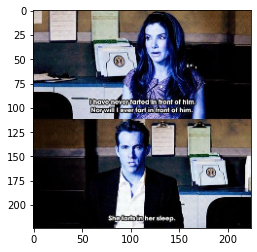

In [60]:
plt.imshow(image)

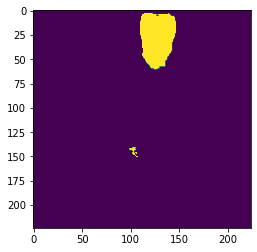

In [61]:
plt.imshow(pred_mask)

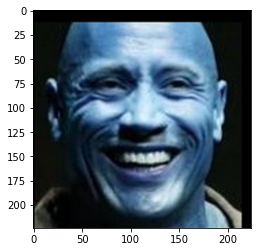

In [55]:
filename2 = './Part 2 - Test Image - Dwayne Johnson4.jpg'
unscaled2 = cv2.imread(filename2)
image2 = cv2.resize(unscaled2, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled2 = preprocess_input(np.array(image2, dtype=np.float32))
y_pred2 = model.predict(np.array([feat_scaled2]))
#y_pred2
pred_mask2 = cv2.resize((1.0*(y_pred2[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(image2)


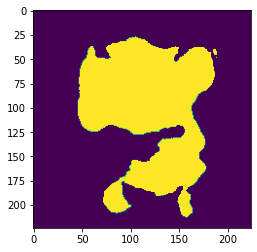

In [56]:
plt.imshow(pred_mask2)